In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from pathlib import Path
import concurrent.futures
import re
from collections import defaultdict
import random
from concurrent.futures import ThreadPoolExecutor
import math
from sklearn.cluster import KMeans

from tcia_utils import nbia
import sys
!{sys.executable} -m pip install --upgrade -q tcia_utils
import json
import requests
import configparser
config = configparser.ConfigParser()
config.read("../config.ini")

import openslide
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import VGG19_Weights, ResNet18_Weights
from torchvision import models

with open(config["case_ids"]["case_ids"], "r") as file:
    case_ids = [line.strip() for line in file]

import utils

In [2]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

num_patches = 1000  # arbitrary, #TODO
patch_size = 500   # patch size at 20X

# this loop iterates over the SVS files in the examples_2_patient folder
# and then extracts patches from the tissue mask of each slide

def extract_patches_from_tissue_mask(subject_svs_filepath, num_patches=num_patches, patch_size=patch_size):

    patches_folder = os.path.dirname(subject_svs_filepath) + f"/patches"
    Path(patches_folder).mkdir(parents=True, exist_ok=True)
    print(f"\textracting patches from {subject_svs_filepath}")

    if len(os.listdir(patches_folder)) == num_patches * (len(os.listdir(os.path.dirname(subject_svs_filepath)))-1): # -1 for the patches folder
        return

    svs_file_id = subject_svs_filepath.split('/')[-1][:-4]

    slide = openslide.OpenSlide(subject_svs_filepath)

    level = 2   #TODO be careful, one of the slides crashed at level 1

    thumbnail = slide.read_region((0, 0), level, slide.level_dimensions[level])
    thumbnail = thumbnail.convert("RGB") # convert from PIL format to RGB
    thumbnail_np = np.array(thumbnail) # convert to numpy array

    #### apply otus thresholding to extract tissue mask
    gray = cv2.cvtColor(thumbnail_np, cv2.COLOR_RGB2GRAY)
    _, tissue_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # invert mask so tissue = white (255), background = black (0)
    tissue_mask = cv2.bitwise_not(tissue_mask)

    #############################################  
    #### zooming patches to the tissue mask #####
    #############################################

    # use scale factor instead of resizing (avoid mem error)
    scale_factor = slide.level_downsamples[level]  
    mask_coords = np.column_stack(np.where(tissue_mask > 0))  # (y, x) positions at level 2

    # map mask coordinates to level 0 size (20X magnification)
    scaled_coords = [(int(y * scale_factor), int(x * scale_factor)) for y, x in mask_coords]
    # print("\t-- scaled_coords, first 5 coords:", scaled_coords[:5])  

    # randomly sample coordinates for patches
    sampled_coords = random.sample(scaled_coords, min(num_patches, len(scaled_coords)))

    # collect/save patches
    for i, (y, x) in enumerate(sampled_coords): #, desc="extracting patches"):
        # read the patch from the slide
        patch = slide.read_region((x, y), 0, (patch_size, patch_size))  
        patch = patch.convert("RGB")   # convert from PIL format to RGB
        patch_filename = f"{patches_folder}/{svs_file_id}_{y}_{x}.png"
        patch.save(patch_filename, "PNG")

    slide.close()

    print(f"\tsaved {len(os.listdir(patches_folder))} patches in {patches_folder}")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

#############################################
### data loader for the extracted patches ###
#############################################
class PatchDataset(Dataset):
    """
    Patches
    """
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.files = [os.path.join(self.folder, f) for f in os.listdir(folder)
                      if os.path.isfile(os.path.join(self.folder, f))]
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        # convert from BGR to RGB
        image = cv2.imread(self.files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        # return image object and filename
        filename = self.files[idx].split("\\")[-1]
        return image, filename


#############################################
### define transforms for VGG19 input #######
#############################################
# VGG19 expects 224x224 images and imagnet normalization
# and ResNet18 augmentations # NOTE
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])


#############################################
####### load pre-trained VGG19 model ########
#############################################
#############################################
### extract features for each patch ##########
#############################################
# want to extract a feature vector rather than classification scores.
# thus, build a new Sequential model that goes through
# 1. model.features (convolutional part)
# 2. model.avgpool (adaptive avg pooling)
# 3. flatten (convert a tensor to a vector)
# 4. model.classifier = False 
# result is a some-dimensional feature vector for each patch image

def extract_features_from_all_patches(dataloader, model_name="resnet18", device=device):
    """
    extracts features from patches of one SVS file
    """
    feature_extractor = None

    if model_name == "vgg19":
        # pretrained imagenet
        model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
        model.to(device)
        model.eval()   # no need to train, use the current weights to extract features

        feature_extractor = torch.nn.Sequential(
            model.features,
            model.avgpool,
            torch.nn.Flatten(),
        *list(model.classifier.children())[:-1] # remove the last layer
    ).to(device)

    elif model_name == "resnet18":
        model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        model.to(device)
        model.eval()   # no need to train, use the current weights to extract features

        feature_extractor = torch.nn.Sequential(
            *list(model.children())[:-1],  # all layers except the final fc layer
            torch.nn.Flatten()
        ).to(device)

    patches_features = {}

    with torch.no_grad():
        for image, file_name in tqdm(dataloader):
            image = image.to(device)
            features_model = feature_extractor(image)  
            # to numpy array
            patches_features[file_name[0]] = features_model.squeeze(0).cpu().numpy()  

    return patches_features

device: cuda


In [ ]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

selected_cases_to_download = case_ids[130:150] # TODO: just run this immediately

cases_with_big_tumors = [] # visual later, need to find some # TODO to save the original svs files and patch pngs

cases_without_slides = []

num_slides = 5

for case in selected_cases_to_download:

    case_dir = config["wsi"]["wsi_slides"] + case
    os.makedirs(case_dir, exist_ok=True)

    if os.path.exists(f"{case_dir}/patches_features.npy"):
        continue

    # download the slides
    try:
        utils.download_slides(case, case_dir, num_slides=num_slides)
        if len(os.listdir(case_dir)) not in range(1, num_slides+1):
            cases_without_slides.append(case)
            continue
    except Exception as e:
        print(e)
        continue
    print(f"{case}'s {len(os.listdir(case_dir))} slides are downloaded")

    # extract patches from tissue mask from each svs slide
    svs_paths = [f"{case_dir}/{svs_file}" for svs_file in os.listdir(case_dir) if svs_file.endswith('.svs')]
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        executor.map(extract_patches_from_tissue_mask, svs_paths)

    # after getting the patches, delete all the SVS files
    # to save space # NOTE: very important
    for svs_file in svs_paths:
        os.remove(svs_file)

    # extracting features from all patches (from all svs slides) of this case
    patches_folder = f"{case_dir}/patches"
    dataset = PatchDataset(patches_folder, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    print(f"\textracting features from {len(dataset)} patches")
    patches_features = extract_features_from_all_patches(dataloader, model_name="resnet18", device=device)

    # save the features to a npy file
    np.save(f"{case_dir}/patches_features.npy", patches_features)

    # delete the patches folder to save space
    shutil.rmtree(patches_folder)

print("cases without slides:", cases_without_slides)

# # NOTE: to delete
# # visual purpose for this cohort
# # write the case ids to a file
# with open("case_ids_80_90_visual.txt", "w") as file:
#     for case in cases_with_big_tumors:
#         file.write(case + "\n")


TCGA-CZ-4861's 5 slides are downloaded
	extracting patches from D:/data/wsi_slides/TCGA-CZ-4861/TCGA-CZ-4861-01A-01-BS1.0423224b-41be-4b4c-8e5e-96c557efeb01.svs
	extracting patches from D:/data/wsi_slides/TCGA-CZ-4861/TCGA-CZ-4861-01A-01-TS1.58c45e80-927c-402c-9ea1-8e311a482dd5.svs
	extracting patches from D:/data/wsi_slides/TCGA-CZ-4861/TCGA-CZ-4861-01Z-00-DX1.c36faa05-5e3b-4711-897e-c91f84405870.svs
	extracting patches from D:/data/wsi_slides/TCGA-CZ-4861/TCGA-CZ-4861-11A-01-BS1.4d4e9433-25a2-4429-a8e8-24185be1370d.svs
	extracting patches from D:/data/wsi_slides/TCGA-CZ-4861/TCGA-CZ-4861-11A-01-TS1.50ae1b7b-7878-44c0-b8ff-23b2f71245db.svs
	saved 4705 patches in D:/data/wsi_slides/TCGA-CZ-4861/patches
	saved 4798 patches in D:/data/wsi_slides/TCGA-CZ-4861/patches
	saved 4841 patches in D:/data/wsi_slides/TCGA-CZ-4861/patches
	saved 4969 patches in D:/data/wsi_slides/TCGA-CZ-4861/patches
	saved 5000 patches in D:/data/wsi_slides/TCGA-CZ-4861/patches
	extracting features from 5000 patch

100%|██████████| 5000/5000 [06:31<00:00, 12.78it/s]


TCGA-CZ-5454's 4 slides are downloaded
	extracting patches from D:/data/wsi_slides/TCGA-CZ-5454/TCGA-CZ-5454-01A-01-BS1.b5e5e9cf-7890-4526-803f-4e0e40798e40.svs
	extracting patches from D:/data/wsi_slides/TCGA-CZ-5454/TCGA-CZ-5454-01A-01-TS1.a00b6c10-c0af-4c0c-8c08-4683d33877ee.svs
	extracting patches from D:/data/wsi_slides/TCGA-CZ-5454/TCGA-CZ-5454-01Z-00-DX1.c82ae31e-d805-4f7c-aca5-894ccf9fdd47.svs
	extracting patches from D:/data/wsi_slides/TCGA-CZ-5454/TCGA-CZ-5454-11A-01-TS1.7fe9df1e-190d-464e-acaf-5ea7222aecf4.svs
	saved 3261 patches in D:/data/wsi_slides/TCGA-CZ-5454/patches
	saved 3507 patches in D:/data/wsi_slides/TCGA-CZ-5454/patches
	saved 3562 patches in D:/data/wsi_slides/TCGA-CZ-5454/patches
	saved 4000 patches in D:/data/wsi_slides/TCGA-CZ-5454/patches
	extracting features from 4000 patches


100%|██████████| 4000/4000 [04:50<00:00, 13.76it/s]


TCGA-DV-A4W0's 4 slides are downloaded
	extracting patches from D:/data/wsi_slides/TCGA-DV-A4W0/TCGA-DV-A4W0-01A-01-TSA.A50DF323-05D4-4134-95B4-504B807B6031.svs
	extracting patches from D:/data/wsi_slides/TCGA-DV-A4W0/TCGA-DV-A4W0-01Z-00-DX1.B9EFDA21-A24B-46B2-999A-9E0865615D27.svs
	extracting patches from D:/data/wsi_slides/TCGA-DV-A4W0/TCGA-DV-A4W0-05A-01-TSA.AD2454E3-1577-445E-887C-E76E6CF96CBB.svs
	extracting patches from D:/data/wsi_slides/TCGA-DV-A4W0/TCGA-DV-A4W0-05Z-00-DX1.873A695C-2FEC-4238-9DA5-45CBD2DF30D9.svs
	saved 3138 patches in D:/data/wsi_slides/TCGA-DV-A4W0/patches
	saved 3285 patches in D:/data/wsi_slides/TCGA-DV-A4W0/patches
	saved 3979 patches in D:/data/wsi_slides/TCGA-DV-A4W0/patches
	saved 4000 patches in D:/data/wsi_slides/TCGA-DV-A4W0/patches
	extracting features from 4000 patches


100%|██████████| 4000/4000 [06:29<00:00, 10.27it/s]


TCGA-BP-5196's 4 slides are downloaded
	extracting patches from D:/data/wsi_slides/TCGA-BP-5196/TCGA-BP-5196-01A-01-BS1.ff9e832e-957b-412f-9633-e0d4d7888b77.svs
	extracting patches from D:/data/wsi_slides/TCGA-BP-5196/TCGA-BP-5196-01A-01-TS1.a564c3ba-c378-45d5-8779-d78409e8dd98.svs
	extracting patches from D:/data/wsi_slides/TCGA-BP-5196/TCGA-BP-5196-01Z-00-DX1.85bc950b-ed4a-4f77-8c17-b2916d0a05de.svs
	extracting patches from D:/data/wsi_slides/TCGA-BP-5196/TCGA-BP-5196-11A-01-TS1.16a278bd-3ddd-4984-862d-76c1b4397b78.svs
	saved 3524 patches in D:/data/wsi_slides/TCGA-BP-5196/patches
	saved 3696 patches in D:/data/wsi_slides/TCGA-BP-5196/patches
	saved 3756 patches in D:/data/wsi_slides/TCGA-BP-5196/patches
	saved 4000 patches in D:/data/wsi_slides/TCGA-BP-5196/patches
	extracting features from 4000 patches


100%|██████████| 4000/4000 [03:44<00:00, 17.81it/s]


TCGA-BP-5004's 4 slides are downloaded
	extracting patches from D:/data/wsi_slides/TCGA-BP-5004/TCGA-BP-5004-01A-01-BS1.7271349c-bf09-483c-8e4a-f0e2b4cab26e.svs
	extracting patches from D:/data/wsi_slides/TCGA-BP-5004/TCGA-BP-5004-01A-01-TS1.39040138-c857-48f5-859d-2c9d9c9e7ec4.svs
	extracting patches from D:/data/wsi_slides/TCGA-BP-5004/TCGA-BP-5004-01Z-00-DX1.46d61a35-7e4f-4fce-9785-8efe255852f0.svs
	extracting patches from D:/data/wsi_slides/TCGA-BP-5004/TCGA-BP-5004-11A-01-TS1.fff06ee1-01d0-4725-b494-cc97316c60f5.svs


TCGA-B0-5399

# Sanity check

In [9]:
selected_cases_to_download

['TCGA-DV-5567',
 'TCGA-BP-5191',
 'TCGA-B8-4148',
 'TCGA-CJ-4636',
 'TCGA-CZ-4865',
 'TCGA-BP-5199',
 'TCGA-DV-5566',
 'TCGA-CJ-4871',
 'TCGA-BP-4973',
 'TCGA-CJ-4905']

available levels and their dimensions: ((84000, 43527), (21000, 10881), (5250, 2720), (2625, 1360))
image dimensions at level 0: (84000, 43527)


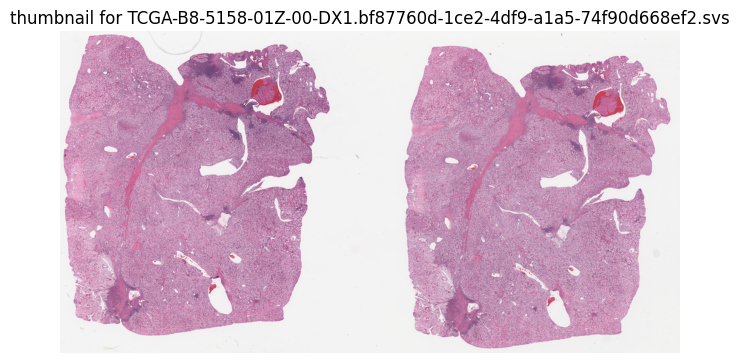

available levels and their dimensions: ((84000, 43527), (21000, 10881), (5250, 2720), (2625, 1360))
width and height at chosen level 2: 5250 2720


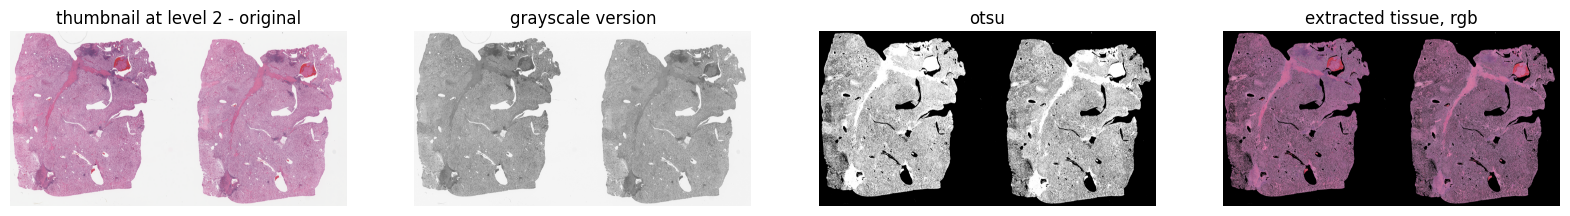

In [37]:
case_dir = config["wsi"]["wsi_slides"] + case_ids[0]
svs_paths = [f"{case_dir}/{svs_file}" for svs_file in os.listdir(case_dir) if svs_file.endswith('.svs')]
utils.display_wsi(svs_paths[2])
utils.display_tissue_extraction(svs_paths[2])

available levels and their dimensions: ((24001, 28637), (6000, 7159), (1500, 1789))
image dimensions at level 0: (24001, 28637)


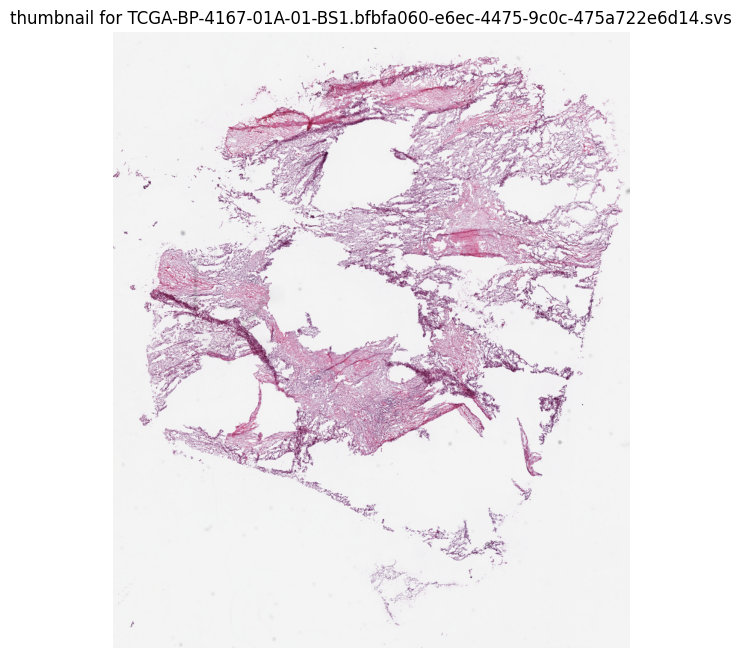

available levels and their dimensions: ((24001, 28637), (6000, 7159), (1500, 1789))
width and height at chosen level 2: 1500 1789


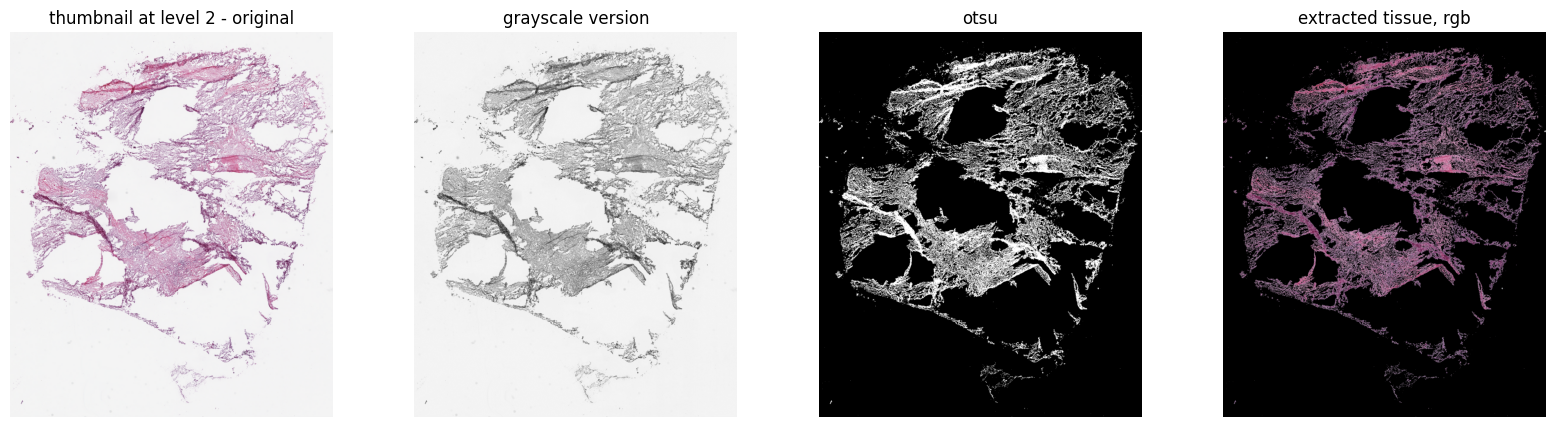

In [38]:
case_dir = config["wsi"]["wsi_slides"] + case_ids[1]
svs_paths = [f"{case_dir}/{svs_file}" for svs_file in os.listdir(case_dir) if svs_file.endswith('.svs')]

utils.display_wsi(svs_paths[0])
utils.display_tissue_extraction(svs_paths[0])

In [24]:
case_dir_1 = config["wsi"]["wsi_slides"] + case_ids[26]
print(case_dir_1)
case_dir_2 = config["wsi"]["wsi_slides"] + case_ids[30]
print(case_dir_2)

data1 = np.load(f"{case_dir_1}/patches_features.npy", allow_pickle=True).item() 

data2 = np.load(f"{case_dir_2}/patches_features.npy", allow_pickle=True).item() 


for value, _ in zip(data2.values(), range(5)):
    print(value.shape)


D:/data/wsi_slides/TCGA-CJ-5686
D:/data/wsi_slides/TCGA-B0-5106
(512,)
(512,)
(512,)
(512,)
(512,)


# Clustering

Embedding process:

- Each patient has no. clusters
- For each cluster, train a FCN to get the local rep for the patches of that cluster
- So then a patient has these local reps, use them to have attention and then final one-vector rep of a patient
- Final output
    - rows: patient/case ids
    - columns: final attention rep vectors

Use the above embedding to Cox directly

# Attention

file:///C:/Users/ASUS/Downloads/2009.11169v1.pdf

- Each patch has a cluster id === a cluster is consisted of a bunch patches/features_extracted (separate stage)
- A patient has clusters (fixed as inputs) and 1 cluster = 1 instance
- A patient: >>> extract features of the png patches for each instance/cluster
    - (1) put **png patches** of each instance (cluster of patches) through a model like MI-FCN (multiple instance fully CNN).
        - Quote: "We embed multiple sub-networks running inside our deep learning architecture with weights being shared among them as in the siamese architecture. Each sub-network is based on fully convolutional neural networks (FCN) that can learn informative representation for individual phenotype of the patient"
        - sub-networks use the same parameters (weights) (siamese) where two or more identical networks process different inputs. sharing weights helps each sub-network extract features in the same way and reduce the number of parameters
        - sub-networks are FULLY CONV network, meaning NO FULLY CONNECTED NETWORK for output like for classification/regression prediction; basically, stop at the feature extracted
        - Since the number of patches in each phenotype varies, the fully convolutional network is more flexible to handle this scenario.
        - trainable weights
        - output: each instance has a local rep 
        - 5 instances/clusters mean 5 vectors  $r_i$
    - (2) pool these local reps using attention model (with trainable weights to Cox loss) to condense these reps into one learned/best representation per patient ($\vec{z}$ with 64x1 dim)
- the trainable weights correspond to backprop on SGD towards Cox loss



The patient-level representation can be calculated as

$$
\mathbf{z} = \sum_{k=1}^{C} a_k \mathbf{r}_k,
$$

where

$$
a_k = \frac{\exp\{\mathbf{w}^\top \tanh(\mathbf{V} \mathbf{r}_k^\top)\}}{\sum_{j=1}^{C} \exp\{\mathbf{w}^\top \tanh(\mathbf{V} \mathbf{r}_j^\top)\}}.
$$

Quote: "In the weight $a_k$ calculation, $\mathbf{w} \in \mathbb{R}^{L \times 1}$ and $\mathbf{V} \in \mathbb{R}^{L \times M}$ are trainable parameters. Tangent $\tanh(.)$ element-wise non-linearity is introduced both negative and positive values for proper gradient flow. The attention-based MIL pooling allows to assign different weights to phenotype clusters within one patient and hence the final patient-level representation could be highly informative for survival prediction."
